## Importing libraries & Reading files

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm

#path of fundamental data file
f_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"

#path of closing prices file 
c_path  = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

#reading files
fdf = pd.read_csv(f_path, encoding='windows-1252')
cdf = pd.read_csv(c_path, encoding='windows-1252')

#fdf.drop(columns=['Unnamed: 0'],inplace=True)
#cdf.drop(columns=['Unnamed: 0'],inplace=True)

# Input Variables
Enter your Input varibales here, in the given format

In [104]:
start_year = 2017           # Format : YYYY

buy_date   = '2023-07-01'   # Format : YYYY-MM-DD
sell_date  = '2024-07-01'   # Format : YYYY-MM-DD

indicator  = "ROCE"         # Format : "ROCE" or "ROE"

m = 0                       # Top companies Ranking from m
n = 30                      # Top companies Ranking till n
                            # Get top m to n companies;    here get Top 0-30 companies

transaction_cost = 0.1      # Percentage of Transaction cost eg.input 1 if you want 1% ; here 0.1 => 0.1%
capital = 1000000           # Capital in the beginning of the backtest


### Getting data from inputs
No output for this code, just some minor calculations.

In [105]:
initial_capital   = capital

buy_date = pd.to_datetime(buy_date)
sell_date = pd.to_datetime(sell_date)

buy_str  = f"-{buy_date.month}-{buy_date.day}"
sell_str = f"-{sell_date.month}-{sell_date.day}"

# Getting End Year date

if buy_date.month > 3:
    end_year = buy_date.year - 2
else :
    end_year = buy_date.year - 3
    
end_year

2021

----

## TRADE SHEET GENERATION CODE
Run this code to get the Trade Sheet

In [106]:
# Blank Dataframe to store Yearly Tradesheet
change = pd.DataFrame()

for year in tqdm(range(start_year, end_year+1)):
    
    f1 = fdf[fdf['Year']==year]
    
    # Fundamental Conditions
    conditions = ["Shareholder's Funds", "PAT", "PBIT"]
    
    for condition in conditions:
        f1 = f1[f1.fillna(0)[condition] > 0]
    
    # Market Cap Condition
    f1 = f1[(f1['Market Cap']>=500) & (f1['Market Cap']<=20000)]
    
    cdf['Date'] = pd.to_datetime(cdf['Date'])
    cdf['Year'] = cdf['Date'].dt.year
    
    # Indicator Conditions
    if indicator == "ROCE" :
        
        # Remove Banking stocks in ROCE
        f1 = f1[~f1['Name'].str.contains('Bank')]
        
        # ROCE Formula
        f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
        #f1[indicator] = (f1['PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

    elif indicator == "ROE" :
        
        # ROE Formula
        f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100
        
        
    # New dataframe to store calculations 
    f2 = f1[['Name',indicator]]                                                            # Name, Indicator
    f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                                        # Buy Date
    
    # Dataframe of companies containing closings on 1st July of start year & next year
    cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
    cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']
    
    
    # Reset Indexes
    f2.reset_index(drop=True,inplace=True)
    cnam.reset_index(drop=True,inplace=True)
    
    
    # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
    f2.rename(columns={'Close':'Close1'},inplace=True)
    
    # SORTING VALUES BY INDICATOR
    f2 = f2.sort_values(by=[indicator], ascending=False)
    
    f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes
    
    # Adding Selling Date
    f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)
    
    # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
    f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
    f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes
    
    # New Dataframe to store Top n Companies and Find Quantity
    f3 = f2[m:n]
    
    #display(f3)
    
    # Filling companies with no Selling Prices with last present close and update the Selling Dates
    for i in range(f3.shape[0]):
        if f3.fillna(0)['Close2'].iloc[i] == 0 :
            f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
            f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()
    
    #display(f3)
    
    # Claculating Quantity
    f3['Qty'] = capital/((n-m)*f3['Close1'])
    
    # Defining a function for Roundown
    def Floor(x):
        try:
            return math.floor(x)
        except:
            return(x)
    
    # Rounddown Quantity
    f3['Qty'] = f3['Qty'].apply(Floor)
    
    # Buying & Selling Value = Qty x Close Price
    f3['Buy Value'] = f3['Qty']*f3['Close1']
    f3['Sell Value'] = f3['Qty']*f3['Close2']
    
    f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100
    
    f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])
    
    #print(f"{year} Starting Capital is {capital}")
    
    capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()
    cagr        = ((capital/initial_capital)**(1/(1))-1)*100
    print(year," CAGR : ", cagr)
    #print(f"{year} Ending Capital is {capital}")
    
    change = change.append(f3)
    
display(change)    

path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{m}-{n}-{transaction_cost}-Reports.xlsx"

change.to_excel(path_to,sheet_name="Trade Sheet")

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100
print(cagr)

  0%|          | 0/5 [00:00<?, ?it/s]

2017  CAGR :  -25.057317984999994
2018  CAGR :  -29.043089434285697
2019  CAGR :  33.13481929199995
2020  CAGR :  10.78311271750001
2021  CAGR :  25.98885749987896


,Name,ROCE,Buy Date,Close1,Sell Date,Close2,Qty,Buy Value,Sell Value,% Change,Transaction Cost
0,Unichem Laboratories Ltd.,114.785886,2018-07-01,235.7000,2019-07-01,171.25,141,33233.700,24146.25,-27.344081,57.379950
1,Castrol India Ltd.,105.011028,2018-07-01,163.7000,2019-07-01,130.00,203,33231.100,26390.00,-20.586439,59.621100
2,Accelya Solutions India Ltd.,83.343225,2018-07-01,1163.8000,2019-07-01,859.85,28,32586.400,24075.80,-26.117030,56.662200
3,Gillette India Ltd.,76.119135,2018-07-01,6420.0500,2019-07-01,7486.95,5,32100.250,37434.75,16.618251,69.535000
4,HEG Ltd.,75.335347,2018-07-01,3310.5000,2019-07-01,1462.65,10,33105.000,14626.50,-55.817852,47.731500
...,...,...,...,...,...,...,...,...,...,...,...
25,Anand Rathi Wealth Ltd.,46.034162,2022-07-01,652.7000,2023-05-10,870.70,56,36551.200,48759.20,33.399724,85.310400
26,Sonata Software Ltd.,45.586528,2022-07-01,496.7625,2023-05-10,851.75,74,36760.425,63029.50,71.460205,99.789925
27,Godawari Power And Ispat Ltd.,45.180094,2022-07-01,254.0000,2023-05-10,373.15,145,36830.000,54106.75,46.909449,90.936750
28,Universus Photo Imagings Ltd.,44.979736,2022-07-01,514.1000,2023-05-10,412.15,71,36501.100,29262.65,-19.830772,65.763750


4.728872389210315


----

## REPORTS GENERATION CODE
Run this code to get the Trade Reports


TOP WINNERS


,Name,Buy Date,% Change
0,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
1,Deepak Nitrite Ltd.,2020-07-01,293.180157
2,Tanfac Industries Ltd.,2022-07-01,241.671931
3,Indiamart Intermesh Ltd.,2020-07-01,223.082839
4,Sonata Software Ltd.,2020-07-01,216.624738
5,Thyrocare Technologies Ltd.,2020-07-01,161.536934
6,Cigniti Technologies Ltd.,2020-07-01,133.849757
7,NBCC (India) Ltd.,2020-07-01,126.709402
8,L&T Technology Services Ltd.,2020-07-01,122.730423
9,IOL Chemicals And Pharmaceuticals Ltd.,2019-07-01,120.672756



TOP LOSERS


,Name,Buy Date,% Change
0,Securekloud Technologies Ltd.,2018-07-01,-82.825089
1,Suumaya Industries Ltd.,2021-07-01,-78.824268
2,EKI Energy Services Ltd.,2022-07-01,-75.896348
3,Paul Merchants Ltd.,2018-07-01,-65.376787
4,NBCC (India) Ltd.,2019-07-01,-61.258278
5,Graphite India Ltd.,2018-07-01,-60.290442
6,Bharat Seats Ltd.,2018-07-01,-59.625422
7,KSE Ltd.,2018-07-01,-58.780161
8,Bhansali Engineering Polymers Ltd.,2018-07-01,-58.158996
9,HEG Ltd.,2018-07-01,-55.817852


  0%|          | 0/5 [00:00<?, ?it/s]


Daily Portfolio Value


,Date,PV
0,2023-06-30 00:00:00,1262238.83
1,2023-06-29 00:00:00,1262238.83
2,2023-06-28 00:00:00,1262238.83
3,2023-06-27 00:00:00,1262238.83
4,2023-06-26 00:00:00,1262238.83
...,...,...
360,2018-07-05 00:00:00,977866.17
361,2018-07-04 00:00:00,981301.825
362,2018-07-03 00:00:00,975628.251667
363,2018-07-02 00:00:00,980850.391667


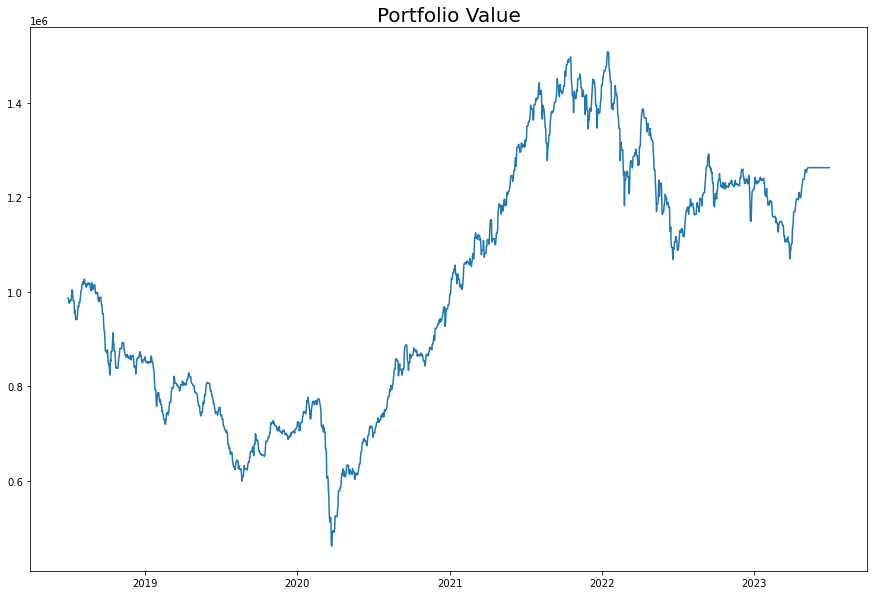

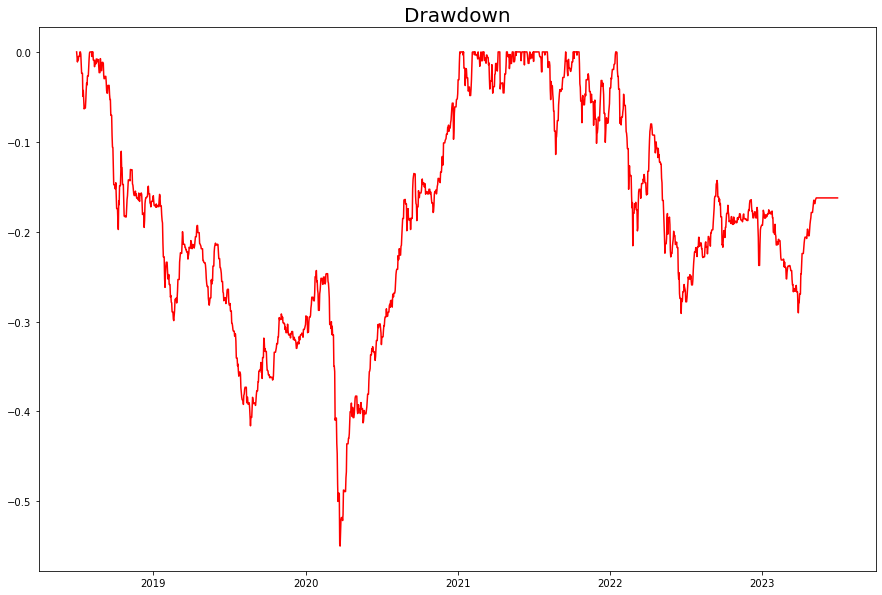

,CAGR,Trading Edge,MDD,CAR/MDD
0,4.728872,12.965342,-54.983615,0.086005


In [107]:
#display(change)

# TOP n Winners & Losers

winners = change[change['% Change']>0].sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers  = change[change['% Change']<0].sort_values(by="% Change", ascending=True )[['Name','Buy Date','% Change']]
winners.reset_index(drop=True, inplace=True)
losers.reset_index(drop=True, inplace=True)


winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


print("\nTOP WINNERS")
display(winners[:10])

print("\nTOP LOSERS")
display(losers[:10])




# Finding Daily Portfolio Value

k = 0

combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    #print(year)
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)
    
    for i in range(k,(n-m)+k):

        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}{buy_str}') & (cdf['Date'] < f'{year+2}{sell_str}')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
        
        
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pv1.append(all_dates.iloc[j])
        
        
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        pv1['PV'] = pv1['Close']*change['Qty'].iloc[i]
        pv1['Date'] = pd.to_datetime(pv1['Date'])
        
#         display(pv1)
#         display(multipv)
        
        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)

    combined_PV = multipv.append(combined_PV)
    k += (n-m)

print("\nDaily Portfolio Value")
display(combined_PV)

print()



combined_PV = combined_PV.sort_values(by='Date', ascending=True)
combined_PV['MDD'] = (combined_PV['PV']/combined_PV['PV'].rolling(len(combined_PV),1).max())-1
combined_PV = combined_PV.sort_values(by='Date',ascending=False)
combined_PV.reset_index(drop=True,inplace=True)



plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["PV"])
plt.title("Portfolio Value", fontsize=20)
plt.show()

plt.figure(figsize=(15,10))
plt.plot(combined_PV["Date"],combined_PV["MDD"],color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr        = ((capital/initial_capital)**(1/(end_year-start_year+1))-1)*100

mdd         = min(combined_PV['MDD'])*100

calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

___________

## Save the Output files
Run this Code to save all the Output Reports & files you get.

In [108]:
with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
    combined_PV.to_excel(writer,sheet_name="Daily Portfolio Value",index=False)
    winners.to_excel(writer,sheet_name="Winners",index=False)
    losers.to_excel(writer,sheet_name="Losers",index=False)
    calc.to_excel(writer,sheet_name="Calculations",index=False)

___________

## Output Variable names
* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown

___________